In [1]:
# Data scienece libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Sci-kit Learn packages
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [2]:
# Read in and preview df
klax_df = pd.read_csv('data/NOAA_LAX_Data_Clean.csv', index_col='YEARMODA')
klax_df.head()

,TEMP,DEWP,VISIB,WDSP,PRCP,FRSHTT,month,FOG_VISIB
YEARMODA,,,,,,,,
1973-01-01,58.6,12.9,10.0,8.7,0.00,clear,1,0
1973-01-02,54.7,27.3,10.0,5.6,0.00,clear,1,0
1973-01-03,53.3,42.4,10.0,7.1,0.00,rain,1,0
1973-01-04,51.5,36.5,10.0,6.2,3.15,rain,1,0
1973-01-05,46.4,29.0,10.0,4.5,0.00,clear,1,0


### About the Data - Exploratory Analysis

In [3]:
# Descriptive statistics across all variables
klax_df.describe()

,TEMP,DEWP,VISIB,WDSP,PRCP,month,FOG_VISIB
count,16387.000000,16387.000000,16387.000000,16387.000000,16387.000000,16387.000000,16387.000000
mean,62.609636,51.722164,8.366919,6.497907,0.040192,6.499969,0.002807
std,5.844357,9.763554,2.177228,1.820386,0.272738,3.449030,0.052909
min,41.300000,-4.000000,0.200000,1.200000,0.000000,1.000000,0.000000
25%,58.200000,47.300000,7.200000,5.400000,0.000000,4.000000,0.000000
50%,62.600000,53.800000,9.500000,6.300000,0.000000,7.000000,0.000000
75%,66.900000,58.900000,10.000000,7.300000,0.000000,9.500000,0.000000
max,86.000000,70.300000,10.000000,19.600000,9.070000,12.000000,1.000000


In [4]:
# Check for null variables
klax_df.isnull().sum()

TEMP         0
DEWP         0
VISIB        0
WDSP         0
PRCP         0
FRSHTT       0
month        0
FOG_VISIB    0
dtype: int64

In [5]:
# Look at unique values for weather events
klax_df['FRSHTT'].unique()

array(['clear', 'rain', 'fog+rain', 'fog'], dtype=object)

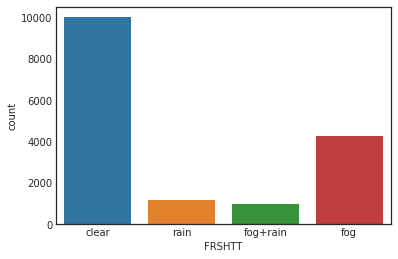

In [6]:
sns.set_style('white')

# Visualize weather events
sns.countplot(x='FRSHTT', data=klax_df)

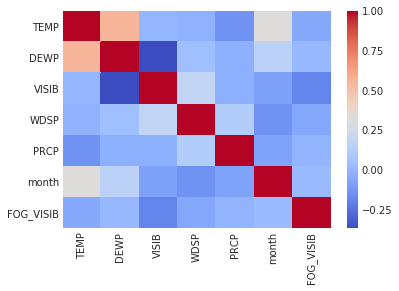

In [7]:
# Heatmap of correlation between variables
sns.heatmap(klax_df.corr(), cmap='coolwarm')

In [8]:
# sns.pairplot(klax_df, hue='FRSHTT')

### Preprocessing data for modeling

In [9]:
# Let's split target prediction into "fog" or "no fog", or 1 or 0, respectively
fog_bins = {'clear': 0, 'rain': 0, 'fog+rain': 1, 'fog': 1}
klax_df['FRSHTT'] = klax_df['FRSHTT'].map(fog_bins)

In [10]:
# Encode weather event as label
weather_event = LabelEncoder()

# Change values to reflect new label
# 0 - clear
# 1 - fog
# 2 - rain
# 3 - fog+rain
klax_df['FRSHTT'] = weather_event.fit_transform(klax_df['FRSHTT'])

In [11]:
# Check df
klax_df.head()

,TEMP,DEWP,VISIB,WDSP,PRCP,FRSHTT,month,FOG_VISIB
YEARMODA,,,,,,,,
1973-01-01,58.6,12.9,10.0,8.7,0.00,0,1,0
1973-01-02,54.7,27.3,10.0,5.6,0.00,0,1,0
1973-01-03,53.3,42.4,10.0,7.1,0.00,0,1,0
1973-01-04,51.5,36.5,10.0,6.2,3.15,0,1,0
1973-01-05,46.4,29.0,10.0,4.5,0.00,0,1,0


Split training and test data

In [12]:
# Configure input features and output label
X = klax_df[['TEMP', 'DEWP', 'VISIB', 'WDSP', 'PRCP', 'month', 'FOG_VISIB']].values
y = klax_df['FRSHTT']

# Preview input array
X[:2]

array([[ 58.6,  12.9,  10. ,   8.7,   0. ,   1. ,   0. ],
       [ 54.7,  27.3,  10. ,   5.6,   0. ,   1. ,   0. ]])

In [13]:
# Standardize scale features for model comparison 
sc = StandardScaler()
X = sc.fit_transform(X)

In [14]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Modeling

In [15]:
# Try decision tree classifer
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
dtree.score(X_test, y_test)

0.75798250966036196

In [16]:
# Run the gamute of classifiers available in scikit-learn to assess accuracy
models = [LogisticRegression(), 
          LinearSVC(), 
          SVC(kernel='rbf'), 
          KNeighborsClassifier(), 
          RandomForestClassifier(), 
          DecisionTreeClassifier(), 
          GradientBoostingClassifier(), 
          GaussianNB()]

model_names = ['Logistic Regression', 
               'Linear SVM', 
               'rbf SVM', 
               'K-Nearest Neighbors', 
               'Random Forest Classifier', 
               'Decision Tree', 
               'Gradient Boosting Classifier', 
               'Gaussian NB']

acc = []
m = {}

for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc.append(accuracy_score(pred, y_test))

m = {'Algorithm':model_names, 'Accuracy':acc}

In [17]:
acc_frame = pd.DataFrame(m)
acc_frame = acc_frame.set_index('Accuracy').sort_index(ascending=False)
acc_frame

,Algorithm
Accuracy,
0.821029,Gradient Boosting Classifier
0.814521,rbf SVM
0.811674,Logistic Regression
0.806996,Linear SVM
0.797031,K-Nearest Neighbors
0.796624,Random Forest Classifier
0.761237,Decision Tree
0.687818,Gaussian NB


In [18]:
# Try Random Forest Classifer
rfc = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100, 200], 
                  'max_features': ['auto', 'sqrt', 'log2'], 
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(rfc, param_grid=parameter_grid, cv=cross_validation, verbose=2)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] criterion=gini, max_features=1, n_estimators=10 .................
[CV] .. criterion=gini, max_features=1, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=1, n_estimators=10 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .. criterion=gini, max_features=1, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=1, n_estimators=10 .................
[CV] .. criterion=gini, max_features=1, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=1, n_estimators=10 .................
[CV] .. criterion=gini, max_features=1, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=1, n_estimators=10 .................
[CV] .. criterion=gini, max_features=1, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=1, n_estimators=10 .................
[CV] .. criterion=gini, max_features=1, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=1, n_estimators=10 .................
[CV] .. criterion=gini, max_features=1, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=1, n_estimators=10 .................
[CV] .. criterion=gini, max_features=1, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=1, n_estimators=10 .................
[CV] .

[CV] .. criterion=gini, max_features=2, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=2, n_estimators=25 .................
[CV] .. criterion=gini, max_features=2, n_estimators=25, total=   0.3s
[CV] criterion=gini, max_features=2, n_estimators=25 .................
[CV] .. criterion=gini, max_features=2, n_estimators=25, total=   0.3s
[CV] criterion=gini, max_features=2, n_estimators=25 .................
[CV] .. criterion=gini, max_features=2, n_estimators=25, total=   0.3s
[CV] criterion=gini, max_features=2, n_estimators=25 .................
[CV] .. criterion=gini, max_features=2, n_estimators=25, total=   0.3s
[CV] criterion=gini, max_features=2, n_estimators=25 .................
[CV] .. criterion=gini, max_features=2, n_estimators=25, total=   0.3s
[CV] criterion=gini, max_features=2, n_estimators=25 .................
[CV] .. criterion=gini, max_features=2, n_estimators=25, total=   0.3s
[CV] criterion=gini, max_features=2, n_estimators=25 .................
[CV] .

[CV] .. criterion=gini, max_features=3, n_estimators=25, total=   0.4s
[CV] criterion=gini, max_features=3, n_estimators=25 .................
[CV] .. criterion=gini, max_features=3, n_estimators=25, total=   0.4s
[CV] criterion=gini, max_features=3, n_estimators=25 .................
[CV] .. criterion=gini, max_features=3, n_estimators=25, total=   0.4s
[CV] criterion=gini, max_features=3, n_estimators=50 .................
[CV] .. criterion=gini, max_features=3, n_estimators=50, total=   0.8s
[CV] criterion=gini, max_features=3, n_estimators=50 .................
[CV] .. criterion=gini, max_features=3, n_estimators=50, total=   0.8s
[CV] criterion=gini, max_features=3, n_estimators=50 .................
[CV] .. criterion=gini, max_features=3, n_estimators=50, total=   0.8s
[CV] criterion=gini, max_features=3, n_estimators=50 .................
[CV] .. criterion=gini, max_features=3, n_estimators=50, total=   0.8s
[CV] criterion=gini, max_features=3, n_estimators=50 .................
[CV] .

[CV] .. criterion=gini, max_features=4, n_estimators=50, total=   1.0s
[CV] criterion=gini, max_features=4, n_estimators=50 .................
[CV] .. criterion=gini, max_features=4, n_estimators=50, total=   1.2s
[CV] criterion=gini, max_features=4, n_estimators=50 .................
[CV] .. criterion=gini, max_features=4, n_estimators=50, total=   1.1s
[CV] criterion=gini, max_features=4, n_estimators=50 .................
[CV] .. criterion=gini, max_features=4, n_estimators=50, total=   1.1s
[CV] criterion=gini, max_features=4, n_estimators=50 .................
[CV] .. criterion=gini, max_features=4, n_estimators=50, total=   1.0s
[CV] criterion=gini, max_features=4, n_estimators=100 ................
[CV] . criterion=gini, max_features=4, n_estimators=100, total=   2.0s
[CV] criterion=gini, max_features=4, n_estimators=100 ................
[CV] . criterion=gini, max_features=4, n_estimators=100, total=   2.0s
[CV] criterion=gini, max_features=4, n_estimators=100 ................
[CV] .

[CV]  criterion=entropy, max_features=1, n_estimators=100, total=   1.4s
[CV] criterion=entropy, max_features=1, n_estimators=100 .............
[CV]  criterion=entropy, max_features=1, n_estimators=100, total=   1.4s
[CV] criterion=entropy, max_features=1, n_estimators=100 .............
[CV]  criterion=entropy, max_features=1, n_estimators=100, total=   1.3s
[CV] criterion=entropy, max_features=1, n_estimators=100 .............
[CV]  criterion=entropy, max_features=1, n_estimators=100, total=   1.4s
[CV] criterion=entropy, max_features=1, n_estimators=100 .............
[CV]  criterion=entropy, max_features=1, n_estimators=100, total=   1.4s
[CV] criterion=entropy, max_features=1, n_estimators=100 .............
[CV]  criterion=entropy, max_features=1, n_estimators=100, total=   1.3s
[CV] criterion=entropy, max_features=1, n_estimators=100 .............
[CV]  criterion=entropy, max_features=1, n_estimators=100, total=   1.4s
[CV] criterion=entropy, max_features=1, n_estimators=200 ......

[CV]  criterion=entropy, max_features=2, n_estimators=200, total=   3.5s
[CV] criterion=entropy, max_features=2, n_estimators=200 .............
[CV]  criterion=entropy, max_features=2, n_estimators=200, total=   3.5s
[CV] criterion=entropy, max_features=2, n_estimators=200 .............
[CV]  criterion=entropy, max_features=2, n_estimators=200, total=   3.6s
[CV] criterion=entropy, max_features=2, n_estimators=200 .............
[CV]  criterion=entropy, max_features=2, n_estimators=200, total=   3.6s
[CV] criterion=entropy, max_features=2, n_estimators=200 .............
[CV]  criterion=entropy, max_features=2, n_estimators=200, total=   3.7s
[CV] criterion=entropy, max_features=2, n_estimators=200 .............
[CV]  criterion=entropy, max_features=2, n_estimators=200, total=   3.6s
[CV] criterion=entropy, max_features=2, n_estimators=200 .............
[CV]  criterion=entropy, max_features=2, n_estimators=200, total=   3.5s
[CV] criterion=entropy, max_features=2, n_estimators=200 ......

[CV]  criterion=entropy, max_features=3, n_estimators=200, total=   4.3s
[CV] criterion=entropy, max_features=4, n_estimators=10 ..............
[CV]  criterion=entropy, max_features=4, n_estimators=10, total=   0.3s
[CV] criterion=entropy, max_features=4, n_estimators=10 ..............
[CV]  criterion=entropy, max_features=4, n_estimators=10, total=   0.3s
[CV] criterion=entropy, max_features=4, n_estimators=10 ..............
[CV]  criterion=entropy, max_features=4, n_estimators=10, total=   0.3s
[CV] criterion=entropy, max_features=4, n_estimators=10 ..............
[CV]  criterion=entropy, max_features=4, n_estimators=10, total=   0.3s
[CV] criterion=entropy, max_features=4, n_estimators=10 ..............
[CV]  criterion=entropy, max_features=4, n_estimators=10, total=   0.3s
[CV] criterion=entropy, max_features=4, n_estimators=10 ..............
[CV]  criterion=entropy, max_features=4, n_estimators=10, total=   0.3s
[CV] criterion=entropy, max_features=4, n_estimators=10 .............

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 10.2min finished


Best score: 0.8073472874839812
Best parameters: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 200}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
"""
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 10.2min finished

Best score: 0.8073472874839812
Best parameters: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 200}

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
"""

In [19]:
rfc = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(rfc, X, y, cv=10), 
                      'classifier': ['Random Forest'] * 10})

rf_df.mean()

accuracy    0.807949
dtype: float64

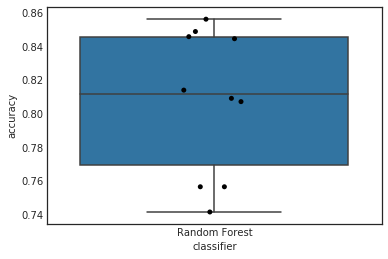

In [20]:
sns.boxplot(x='classifier', y='accuracy', data=rf_df)
sns.stripplot(x='classifier', y='accuracy', data=rf_df, jitter=True, color='black')